In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [3]:
# === 2. DOC DU LIEU ===
df_behavior = pd.read_csv("E:\\TrainAI\\extended_ecommerce_sales_forecast_dataset.csv")
df_sales = pd.read_csv("E:\\TrainAI\\ecommerce_sales_analysis (1).csv")


In [4]:
# === 2.1 FEATURE ENGINEERING ===
# Tạo các đặc trưng mới từ dữ liệu sales
sales_cols = [col for col in df_sales.columns if "sales_month" in col]
df_sales['sales_mean_12m'] = df_sales[sales_cols].mean(axis=1)
df_sales['sales_std_12m'] = df_sales[sales_cols].std(axis=1)
df_sales['sales_min_12m'] = df_sales[sales_cols].min(axis=1)
df_sales['sales_max_12m'] = df_sales[sales_cols].max(axis=1)
df_sales['sales_growth_rate'] = (df_sales[sales_cols[-1]] - df_sales[sales_cols[0]]) / (df_sales[sales_cols[0]] + 1e-6)
df_sales['review_score_per_count'] = df_sales['review_score'] / (df_sales['review_count'] + 1e-6)

# Tính trung bình các đặc trưng mới theo category
feature_cols = [
    'sales_mean_12m', 'sales_std_12m', 'sales_min_12m', 'sales_max_12m',
    'sales_growth_rate', 'review_score_per_count'
]
avg_features_by_cat = df_sales.groupby('category')[feature_cols].mean().reset_index()
avg_features_by_cat.rename(columns={'category': 'Product Categories'}, inplace=True)

# Tạo các đặc trưng tương tác từ df_behavior
df_behavior['engagement_x_ad_spend'] = df_behavior['Engagement Rate'] * df_behavior['Advertising Spend']
df_behavior['discount_x_avg_order'] = df_behavior['Discount Rate'] * df_behavior['Average Order Value']

In [6]:
# Tính tổng sales 12 tháng
sales_cols = [col for col in df_sales.columns if "sales_month" in col]
df_sales['total_sales_12m'] = df_sales[sales_cols].sum(axis=1)

# Tính trung bình doanh thu 12 tháng theo category
avg_sales_by_cat = df_sales.groupby('category')['total_sales_12m'].mean().reset_index()
avg_sales_by_cat.rename(columns={
    'category': 'Product Categories',
    'total_sales_12m': 'avg_sales_last_12_months'
}, inplace=True)

# Merge thêm các đặc trưng mới vào avg_sales_by_cat
avg_sales_by_cat = pd.merge(avg_sales_by_cat, avg_features_by_cat, on='Product Categories', how='left')


In [7]:
# === 4. TIEN XU LY CATEGORY DE KET NOI ===
df_behavior['Product Categories'] = df_behavior['Product Categories'].str.lower().str.strip()
avg_sales_by_cat['Product Categories'] = avg_sales_by_cat['Product Categories'].str.lower().str.strip()


In [8]:
# === 5. KET HOP 2 DATASET ===
df = pd.merge(df_behavior, avg_sales_by_cat, on='Product Categories', how='left')

In [9]:
# === 6. KIEM TRA & XU LY GIA TRI THIEU ===
print("🔍 So dong co NaN:", df.isna().sum().sum())
print("🧹 Cac cot co NaN:\n", df.isna().sum())


🔍 So dong co NaN: 4298
🧹 Cac cot co NaN:
 Customer Behavior                0
Market Trends                    0
Seasonal Fluctuations            0
Product Availability             0
Customer Demographics            0
Website Traffic                  0
Engagement Rate                  0
Discount Rate                    0
Advertising Spend                0
Social Media Engagement          0
Returning Customers Rate         0
New Customers Count              0
Product Categories               0
Average Order Value              0
Shipping Speed                   0
Customer Satisfaction Score      0
Economic Indicator               0
Sales Forecast                   0
engagement_x_ad_spend            0
discount_x_avg_order             0
avg_sales_last_12_months       614
sales_mean_12m                 614
sales_std_12m                  614
sales_min_12m                  614
sales_max_12m                  614
sales_growth_rate              614
review_score_per_count         614
dtype: int64


In [10]:
# Bo dong bi thieu avg_sales_last_12_months
df = df.dropna()

In [11]:
# === 7. CHIA TAP DU LIEU ===
categorical_cols = ['Seasonal Fluctuations', 'Customer Demographics', 'Product Categories']
numerical_cols = [col for col in df.columns if col not in categorical_cols + ['Sales Forecast']]

X = df.drop(columns=['Sales Forecast'])
y = df['Sales Forecast']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# === 8. TAO PIPELINE ===
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])

model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', LinearRegression())
])

In [13]:
# === 9. TRAIN MO HINH ===
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

✅ MAE: 117.93
✅ RMSE: 139.76
✅ R² Score: -0.15


C:\Users\ACER\AppData\Local\Temp\ipykernel_24408\971635819.py:18: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ACER\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


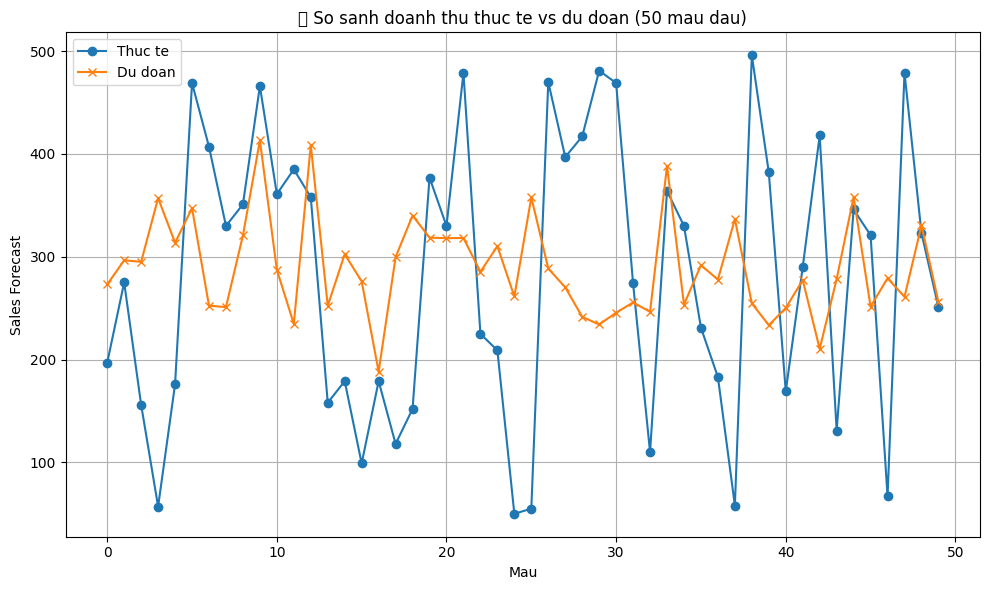

In [14]:
# === 10. DANH GIA ===
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"✅ MAE: {mae:.2f}")
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ R² Score: {r2:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:50], label='Thuc te', marker='o')
plt.plot(y_pred[:50], label='Du doan', marker='x')
plt.title('📊 So sanh doanh thu thuc te vs du doan (50 mau dau)')
plt.xlabel('Mau')
plt.ylabel('Sales Forecast')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:

avg_value = np.round(avg_sales_by_cat[avg_sales_by_cat['Product Categories'] == 'electronics']['avg_sales_last_12_months'].values[0], 2)

new_data = pd.DataFrame({
    'Customer Behavior': [46.0],
    'Market Trends': [0.9],
    'Seasonal Fluctuations': ['High'],
    'Product Availability': [200],
    'Customer Demographics': ['26-35'],
    'Website Traffic': [600],
    'Engagement Rate': [0.07],
    'Discount Rate': [0.25],
    'Advertising Spend': [800],
    'Social Media Engagement': [600],
    'Returning Customers Rate': [0.68],
    'New Customers Count': [40],
    'Product Categories': ['electronics'],
    'Average Order Value': [62.5],
    'Shipping Speed': [3.1],
    'Customer Satisfaction Score': [4],
    'Economic Indicator': [5.0],
    'avg_sales_last_12_months': [avg_value]
})

predicted = model.predict(new_data)
print(f"📦 Du doan doanh thu thang tiep theo: {predicted[0]:.2f}")

ValueError: columns are missing: {'sales_min_12m', 'engagement_x_ad_spend', 'discount_x_avg_order', 'sales_mean_12m', 'sales_std_12m', 'sales_growth_rate', 'sales_max_12m', 'review_score_per_count'}